### docTR + OpenAI API

The moitve behind this project is when I saw my wife spent hours preparing exercice to our son. After diner, she seat at the couch with me and she started reading his textbook and prepare true/false and fill the blanks questions.

So, why not automate this job? I tested ChatGPT giving a text and ask it to create 10 true/false and fill the blanks qustions. It showed me the result, and it was exactly what I wanted. The next step is to find a way to translate the textbook into a digitial format. Unfortunelty, we did not have the pdf of his textbook. So, the solutino is to take a picture and somehow translate into text file.

That's where docTR comes in. docTR is an open soure Optical Character Recognition (OCR) that recognize words in an image and translate into a text format.

Below is a simple proof of concept of this solution.

Please not that this is an on-going project. I will improve the process based on our needs.

### Import all libraries

In [117]:
import pandas as pd

import json
#import os
from pathlib import Path
import shutil
import glob
import re

from doctr.io import DocumentFile
from doctr.models.predictor import OCRPredictor
from doctr.models import recognition, db_resnet50
from doctr.datasets import VOCABS, RecognitionDataset
from doctr.models.detection.predictor import DetectionPredictor
from doctr.models.recognition.predictor import RecognitionPredictor
from doctr.models.preprocessor import PreProcessor


from dotenv import dotenv_values
import openai

### Constants

In [145]:
IMAGE_PATH = ".//images//"
OUTPUT_TEXT_FROM_IMAGE = ".//text_from_images//"
EXAM_QUESTIONS_DIR = ".//exam_questions//"

# Questions type
TOTAL_QUESTION = 5
FILL_BLANKS = [ "fill the blanks", "fill_blanks"]
TRUE_FALSE = ["true or false", "true_false"]
MULTIPLE_CHOICES = ["Multiple choices", "multiple_choice"]

### Functions

In [137]:
def get_images(path=IMAGE_PATH, patter="*"):
    """
    Return a list with all files in the directory
    Parameters:
        path (string): the directory where the files are stored
    """
    #files = sorted(os.walk(path))
    files = glob.glob(path + patter)
    files = [f for f in files if os.path.isfile(f)]
    
    return sorted(files)

In [120]:
def write_file(file_name, text_to_file, path=OUTPUT_TEXT_FROM_IMAGE, extension=".txt"):
    file = open(path + file_name + extension, "w", encoding='utf-16')
    file.write(text_to_file)
    file.close()

In [121]:
def move_file(file, final_path=IMAGE_PATH + "processed"):
    shutil.move(file, final_path)

In [122]:
def generate_exam(text, exam_type="True or False", number_questions=None):
    """
    
    Parameters:
        text (str): The text that ChatGPT will use to generate the exam.
        exam_type (str): type of exam. It could be 'fill the blanks', 'true or False', 'multipe questions'
    """
    #if (number_questions is not None):
    #    number_question_text = f"{number_questions}"
    system_msg = f"You are a teacher specialized in history of Canada. \
                  I will send you a text regarding Canadian history, \
                  and I would like that you create an exam for a 10 years old kid \
                  The goal is to practice for the next exame at school. \
                  So, please generate from follwoing exam with {number_questions} questions, {exam_type} style exam: {text} \
                  Also provide the anwsers for each question at the and. \
                  "
    # otherwise, the final answer will have weird characters.
    #system_msg.encode("utf-8").decode()
    messages = [
        {"role": "system", "content": system_msg 
        }
    ]  
    
    response = openai.ChatCompletion.create(
        messages = messages,
        model = "gpt-3.5-turbo",
        max_tokens = 500,
    )
    exam = response["choices"][0]["message"]["content"]
    return exam

### Main flow

In [123]:
config = dotenv_values("../env.txt")
openai.api_key = config["OPENAI_KEY"]

In [139]:
files = get_images()
files

['.//images/pag87.jpg', './/images/pag88.jpg']

In [140]:
## Model instance ##

model = recognition.__dict__["crnn_mobilenet_v3_large"](pretrained=True, vocab=VOCABS["french"])
predictor = RecognitionPredictor(PreProcessor((32, 128), preserve_aspect_ratio=True, batch_size=32, mean=(0.694, 0.695, 0.693), std=(0.299, 0.296, 0.301)), model)
det_model = db_resnet50(pretrained=True)
det_predictor = DetectionPredictor(PreProcessor((1280, 1280), batch_size=1, mean=(0.798, 0.785, 0.772), std=(0.264, 0.2749, 0.287)), det_model)

# final predictor
predictor = OCRPredictor(det_predictor, predictor)

In [141]:
## loop for all images and generate the text file ##

# get the base file name for the final file with all text combined
text_file_name = os.path.basename(files[0]).split(".")[0]

text = ""
for file_name in files:
    print(f"Converting the image file {os.path.basename(file_name)}...")
    document = DocumentFile.from_images(file_name)
    result = predictor([document[0]])
    text += result.render()
    move_file(file_name)

write_file(file_name=text_file_name, text_to_file=text)
print(f"File '{text_file_name}' created under {OUTPUT_TEXT_FROM_IMAGE}")

Converting the image file pag87.jpg...
Converting the image file pag88.jpg...
File 'pag87' created under .//text_from_images//


In [143]:
# generate the exam
exam = generate_exam(text=text, exam_type=TRUE_FALSE[0], number_questions=TOTAL_QUESTION)
write_file(file_name="exam_"+text_file_name+"_"+TRUE_FALSE[1], path=EXAM_QUESTIONS_DIR, text_to_file=exam)

In [77]:
# generate the exam
exam = generate_exam(text=text, exam_type=FILL_BLANKS[0], number_questions=TOTAL_QUESTION)
write_file(file_name="exam_"+text_file_name+"_"+FILL_BLANKS[1], path=EXAM_QUESTIONS_DIR, text_to_file=exam)

In [146]:
# generate the exam
exam = generate_exam(text=text, exam_type=MULTIPLE_CHOICES[0], number_questions=TOTAL_QUESTION)
write_file(file_name="exam_"+text_file_name+"_"+MULTIPLE_CHOICES[1], path=EXAM_QUESTIONS_DIR, text_to_file=exam)

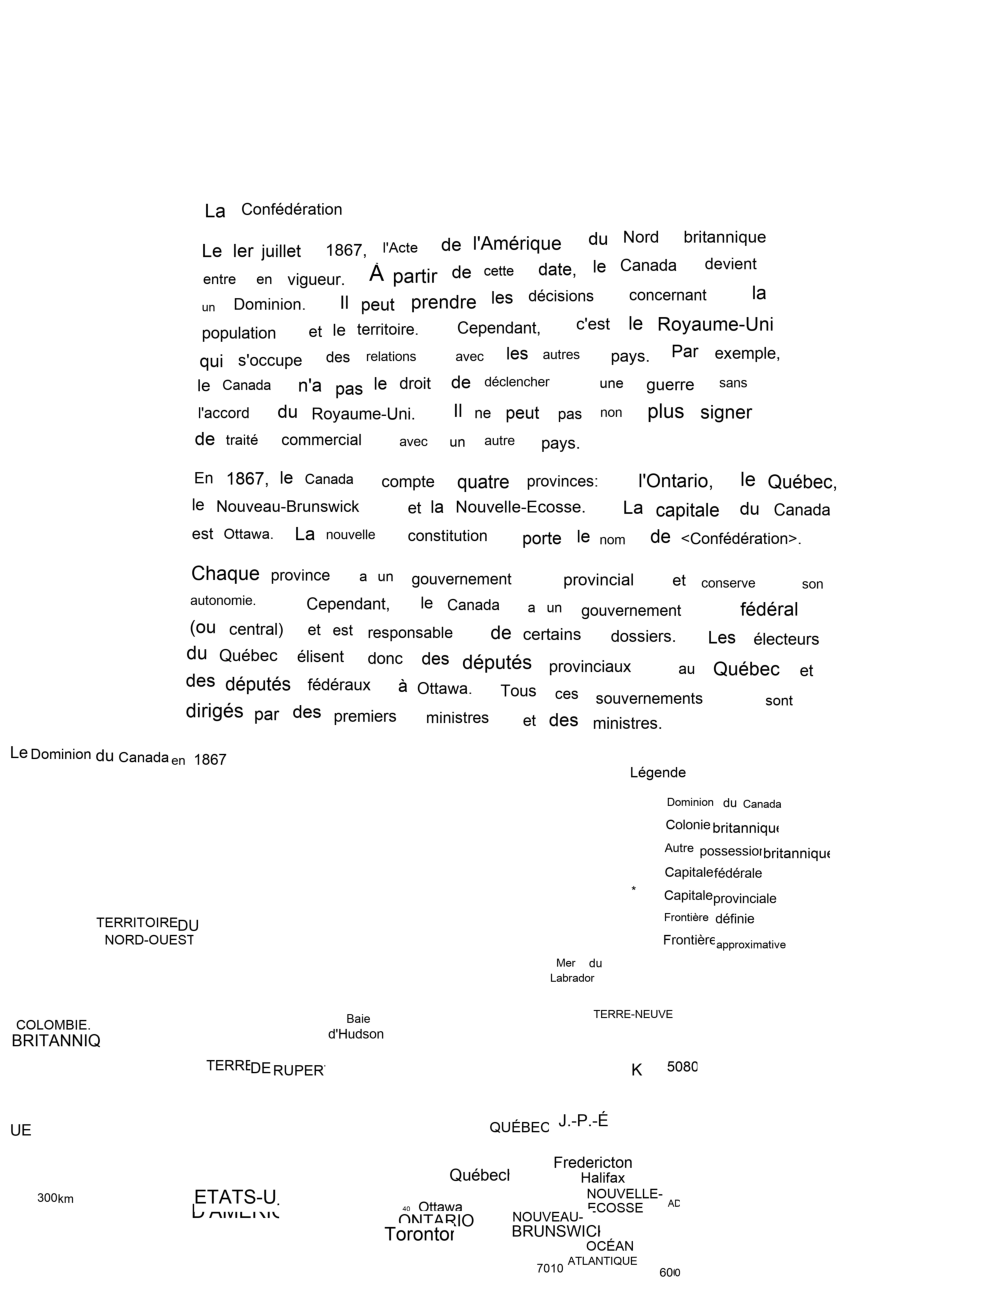

In [ ]:
import matplotlib.pyplot as plt
plt.rcParams["figure.figsize"] = [10.00, 20.00]
plt.rcParams["figure.autolayout"] = True

synthetic_pages = result.synthesize()
plt.imshow(synthetic_pages[0]); plt.axis('off'); plt.show()